# Multilayer perceptron with PyTorch

### Problem formulation

Let $\mathbf{x} \in \mathbb{R}^2$ denote the input vector and $y \in \{0,1\}$ the corresponding label.

We assume that there exist a function $f(\cdot; \boldsymbol\theta): \mathbb{R}^2 \mapsto [0,1]$ parametrized by $\boldsymbol\theta$ such that:

$$p(y=1|\mathbf{x} ; \theta) = f(\mathbf{x}; \boldsymbol\theta) = \hat{y}, \qquad p(y=0|\mathbf{x} ; \theta) = 1- f(\mathbf{x}; \boldsymbol\theta) = 1- \hat{y}$$

Let's first load the data.

In [1]:
my_seed = 1
import numpy as np
np.random.seed(my_seed)
import torch
torch.manual_seed(my_seed)
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import plot_data, plot_decision_boundary
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
X, Y = make_moons(n_samples=2000, noise=0.1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=my_seed)

X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
Y_val_tensor = torch.from_numpy(Y_val).float()

print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(X_val_tensor.shape)
print(Y_val_tensor.shape)

torch.Size([1600, 2])
torch.Size([1600])
torch.Size([400, 2])
torch.Size([400])


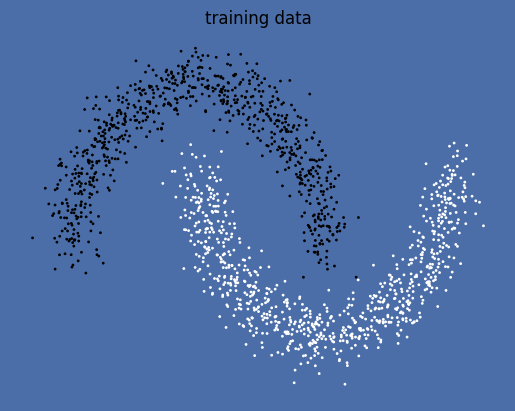

In [3]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_title('training data')
plot_data(ax, X_train, Y_train)

### Model

In PyTorch, define a class `MyFirstMLP` that implements a simple multi-layer perceptron with one hidden layer. This class should inherits from [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), the base class for all neural network modules in PyTorch.

In [4]:
class MyFirstMLP(nn.Module):

    ########### TODO ##########
    def __init__(self, input_dim=2, output_dim=1, hidden_dim=50):
        
        super(MyFirstMLP, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.tanh(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        
        return x
    ##########

We can instanciate this MLP, which creates a model with randomly initialized parameters. Let's have a look to the resulting decision boundary.

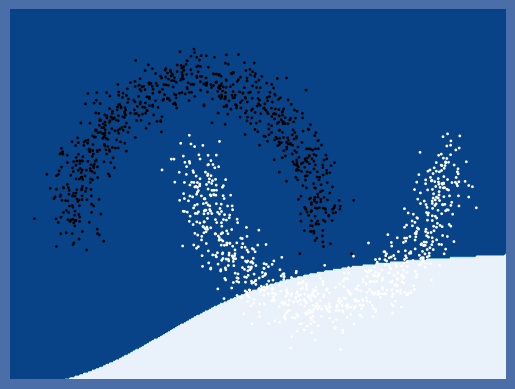

In [5]:
my_nn = MyFirstMLP(input_dim=2, output_dim=1, hidden_dim=50)

fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_decision_boundary(ax, X_train_tensor, Y_train_tensor, my_nn, use_tensor=True)

### Training

Now we need to train the model from a labeled training dataset $\mathcal{D} = \{\mathbf{x}_i, y_i\}_{i=1}^N$. As seen during the lesson, we need to define a loss function:

$$\mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^N \ell(y_i, \hat{y}_i = f(\mathbf{x}_i; \boldsymbol\theta)).$$

For binary classification we use the **binary cross-entropy** loss:

$$ \ell(y, \hat{y}) = - (y \ln(\hat{y}) + (1-y)\ln(1-\hat{y})). $$

To estimate the model parameters $\boldsymbol\theta$ we have to minimize the loss function $\mathcal{L}(\boldsymbol\theta)$. To do so, we can use the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm. It is an iterative algorithm which consists in iterating:

$$ \boldsymbol\theta \leftarrow \boldsymbol\theta - \gamma \nabla \mathcal{L}(\boldsymbol\theta), $$

where $\gamma$ is the learning rate. Both the learning rate and the initialization of the parameters have a critical influence on the behavior of the algorithm.

We have seen during the lesson that the gradient is computed using an algorithm called backpropagation. Fortunately, PyTorch handles this step automatically.

In the following cell, implement the PyTorch pipeline to train the model `my_nn`.

In [6]:
# We turn our model in train mode. Some layers that we do not use here 
# behave differently on train and eval mode. 
my_nn.train() 

# We define some hyperparameters
learning_rate = 1
num_epochs = 200

# We define the optimizer
optimizer = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)

# We define the loss
loss_fn = nn.BCELoss(reduction='mean')

train_loss = []
val_loss = []

for epoch in range(num_epochs):

    # reset the stored gradients for the parameters of the neural network
    my_nn.zero_grad() 

    # do the forward pass
    Y_hat = my_nn(X_train_tensor)
    
    # compute and store the loss on the training set
    loss = loss_fn(Y_hat, Y_train_tensor.unsqueeze(1)) # compute the loss
    train_loss.append(loss.item()) # store the loss
    
    # do the backward pass
    loss.backward() 
    
    # do a gradient descent step
    optimizer.step() 
    ## this is equivalent to:
    # for p in my_nn.parameters():
    #    p.data = p.data - learning_rate*p.grad.data
    
    # compute and store the loss on the validation set
    Y_hat = my_nn(X_val_tensor) # do the forward pass
    loss = loss_fn(Y_hat, Y_val_tensor.unsqueeze(1)) # compute the loss
    val_loss.append(loss.item()) # store the loss

Text(0.5, 0, 'epochs')

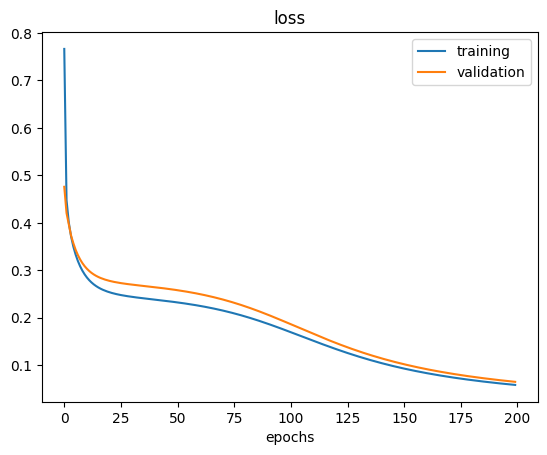

In [7]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["training", "validation"])
plt.title("loss")
plt.xlabel("epochs")

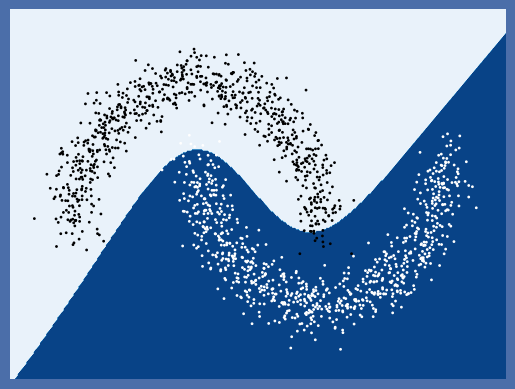

In [8]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_decision_boundary(ax, X_train_tensor, Y_train_tensor, my_nn, use_tensor=True)

## Questions

- What results do you obtain if you remove the hidden layer? Why?
- What results do you obtain if you add one or several hidden layers?
- What happens if you choose a learning rate that is either too low or too high?
- How can you use the validation set to choose the number of hidden layers and the number of training iterations?